In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.font_manager as fm 
import matplotlib.patches as patches

In [2]:
# Load the "Jost" font needed for this plot
font_dir = ['./source/Jost_Font/']  # Font is located in Jost_Font folder
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)

In [3]:
# Load datasets needed for this plot

# Voter participation data
data_participation = pd.read_csv("./source/NRW2023-wahlbeteiligung.csv", sep=';')

# Language area data
data_language = pd.read_csv("./source/language_per_municipality.csv", sep=';')

# Swiss map boundaries data
border_folder = Path("./source/boundaries")
map_canton = gpd.read_file(str(border_folder / "k4k23.shx"))
map_municipality = gpd.read_file(str(border_folder / "k4g23.shx"))

In [4]:
# Adjust data to needs of this plot

# Only use voter data of municipalities
data_municipality = data_participation[data_participation["ebene_resultat"].isin(["Gemeinde"])]
# Add a column with canton abbreviations for annotations
data_municipality["kanton_abbr"] = data_municipality["kanton_nummer"].map({1: "ZH", 2: "BE", 3: "LU", 4: "UR", 5: "SZ", 6: "OW", 7: "NW", 8: "GL", 9: "ZG", 10: "FR", 11: "SO", 12: "BS", 13: "BL", 14: "SH", 15: "AR", 16: "AI", 17: "SG", 18: "GR", 19: "AG", 20: "TG", 21: "TI", 22: "VD", 23: "VS", 24: "NE", 25: "GE", 26: "JU",})
# Rename the municipality name column
data_municipality = data_municipality.rename(columns={'geoLevelName': 'GEO_NAME'})
map_municipality = map_municipality.rename(columns={'GMDNAME': 'GEO_NAME'})
# Merge the voter data and the map border data
data_municipality = data_municipality.merge(data_language, on="GEO_NAME")
data_municipality = data_municipality.merge(map_municipality, on="GEO_NAME")
# Add a column with the density of voters in voters per square kilometer
data_municipality["voter_per_qkm2"] = data_municipality["wahlberechtigte"].astype(int) / (data_municipality["AREA_HA"].astype(float) / 100)

C:\Users\dave_\AppData\Local\Temp\ipykernel_20036\646414944.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_municipality["kanton_abbr"] = data_municipality["kanton_nummer"].map({1: "ZH", 2: "BE", 3: "LU", 4: "UR", 5: "SZ", 6: "OW", 7: "NW", 8: "GL", 9: "ZG", 10: "FR", 11: "SO", 12: "BS", 13: "BL", 14: "SH", 15: "AR", 16: "AI", 17: "SG", 18: "GR", 19: "AG", 20: "TG", 21: "TI", 22: "VD", 23: "VS", 24: "NE", 25: "GE", 26: "JU",})


In [5]:
# Create colormap
cmap = {
    'Deutsches Sprachgebiet': '#dccd7d', 
    'Französisches Sprachgebiet': '#5da899',
    'Italienisches Sprachgebiet': '#c26a77', 
    'Rätoromanisches Sprachgebiet': '#7e2954'
}

In [6]:
# Separate the data based on language for regression fitting
languages_separated = {}
for key in cmap.keys():
    languages_separated[key] = data_municipality[data_municipality["DESC_VAL"].isin([key])]

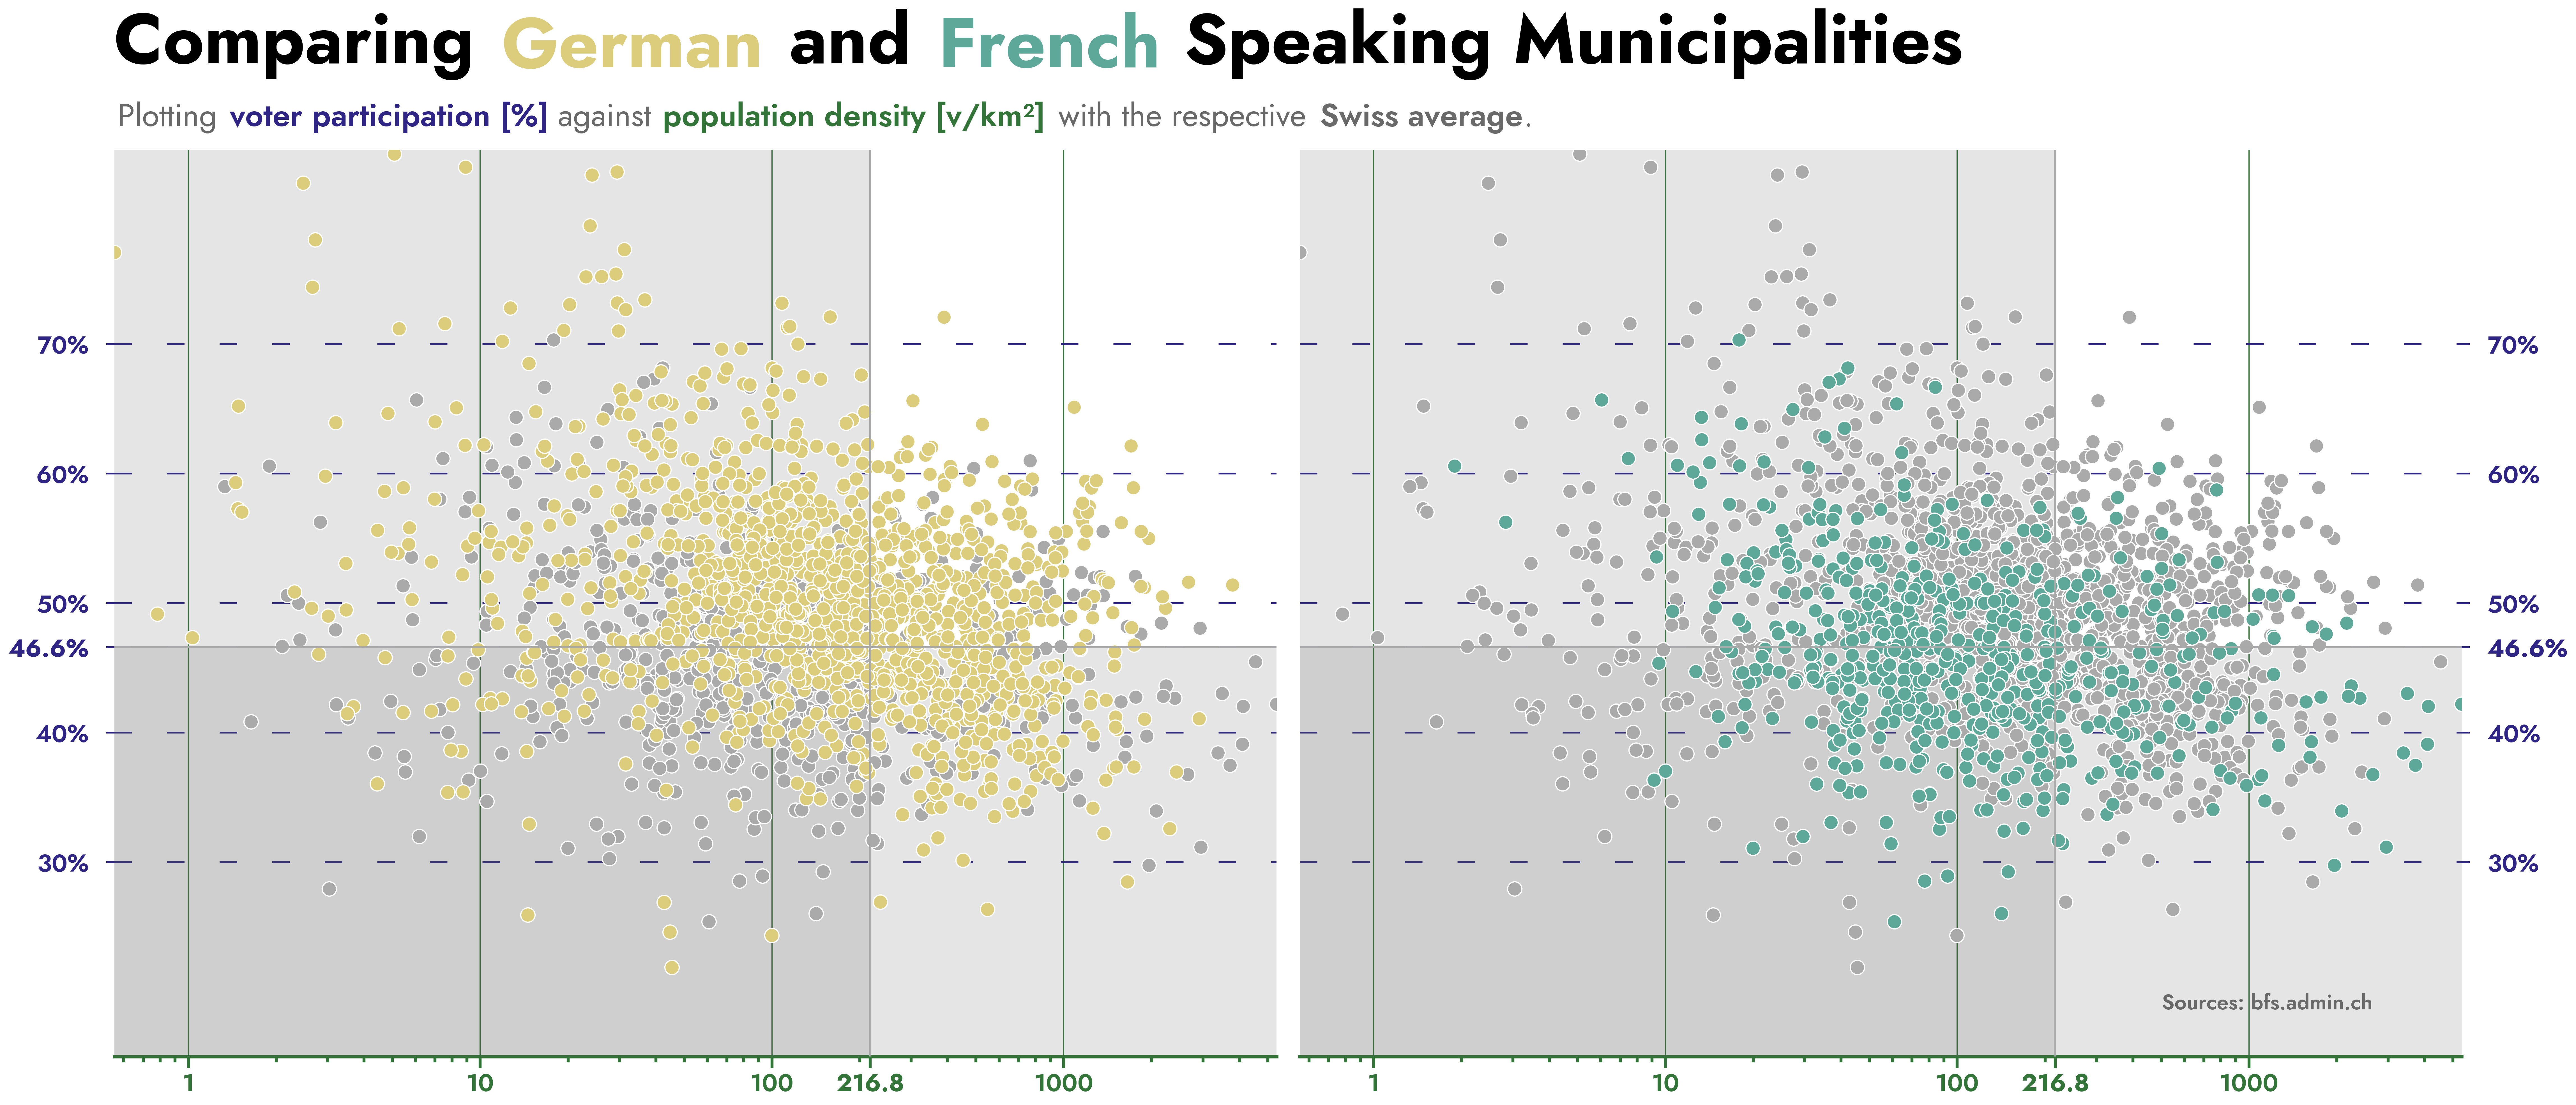

In [130]:
# Create figure and axis
f, ax = plt.subplots(1, 2, sharey=True, figsize=(36, 14), dpi=300)
# Adjust spacing between the graphs
plt.subplots_adjust(wspace=0.02)

for index, (language, color) in enumerate(cmap.items()):
    if language in ['Italienisches Sprachgebiet', 'Rätoromanisches Sprachgebiet']:
        break
    for _language, data in languages_separated.items():
        ax[index].scatter(x='voter_per_qkm2', y='wahlbeteiligung', color=(color if language == _language else '#aaaaaa'), data=data, s=150, edgecolors='white', zorder=95 if language == _language else 90)
        ax[index].set_xscale("log") # Set voter density column to logarithmic scaling

# Style axis
xticks = [1, 10, 100, 216.8, 1000]
xticks_labels = [f'{tick}' for tick in xticks]
yticks = [30, 40, 46.6, 50, 60, 70]
yticks_labels = [f'{tick}%' for tick in yticks]

for index in [0, 1]:

    ax[index].axvspan(0, 216.8, facecolor='#555555', alpha=0.15, zorder=80)
    ax[index].axhspan(0, 46.6, facecolor='#555555', alpha=0.15, zorder=80)
    ax[index].axvline(x=216.8, color='darkgrey', linewidth=1.5, zorder=97)
    ax[index].axhline(y=46.6, color='darkgrey', linewidth=1.5, zorder=97)

    ax[index].set_ylim(bottom=15, top=85)
    ax[index].set_xlim(left=data_municipality['voter_per_qkm2'].min(), right=data_municipality['voter_per_qkm2'].max())

    # Set x-Ticks
    ax[index].set_xticks(xticks, minor=False)
    ax[index].set_xticklabels(xticks_labels)

    # Set y-Ticks
    ax[index].set_yticks(yticks, minor=False)
    ax[index].set_yticklabels(yticks_labels)

    # Format the ticks and the tick-labels
    ax[index].tick_params(which='major', labelsize=21, labelfontfamily='Jost', labelcolor='dimgrey') # Style all major tick labels
    ax[index].tick_params(axis='x', which='minor', color='#337538', length=5, width=2.5)
    ax[index].tick_params(axis='x', which='major', color='#337538', length=10, width=2.5) # Style x-Axis major ticks
    
    if not index:
        ax[index].tick_params(axis='y', which='major', pad=15, color='#2e2585', length=7, width=1.5) # Style x-Axis major ticks
    else:
        ax[index].tick_params(axis='y', which='major', pad=15, color='#2e2585', length=7, width=1.5, right=True, labelright=True, left=False, labelleft=False) # Style y-Axis major ticks

    ax[index].spines.bottom.set(color='#337538', linewidth=3)

    # Set Axis tick labels to use bold font
    for tick in ax[index].get_yticklabels():
        tick.set_color('#2e2585')
        tick.set_fontweight('semibold')
        if tick.get_text() == '46.6%':
            tick.set_fontweight('bold')

    for tick in ax[index].get_xticklabels():
        tick.set_color('#337538')
        tick.set_fontweight('semibold')
        if tick.get_text() == '216.8':
            tick.set_fontweight('bold')

    # Set the grid to use custom dash style
    ax[index].grid(axis="x", color="#337538", linestyle=(0, (1, 0)), linewidth=1)
    ax[index].grid(axis="y", color="#2e2585", linestyle=(0, (10, 20)), linewidth=1.5)

    # Disable all other spines
    ax[index].spines.top.set_visible(False)
    ax[index].spines.left.set_visible(False)
    ax[index].spines.right.set_visible(False)


# Set title
f.suptitle('Comparing               and             Speaking Municipalities', fontproperties={'family': 'Jost', 'size': 60, 'weight': 'bold'}, x=0.43, y=1)
f.text(x=0.2528, y=0.95, s='German', color='#dccd7d', fontproperties={'family': 'Jost', 'size': 60, 'weight': 'bold'})
f.text(x=0.397, y=0.95, s='French', color='#5da899', fontproperties={'family': 'Jost', 'size': 60, 'weight': 'bold'})

# Set subtitle
f.text(x=0.126, y=0.9, s=f"Plotting                                    against                                           with the respective                       .", color='dimgrey', fontproperties={'family': 'Jost', 'size': 27, 'weight': 'regular'})
f.text(x=0.163, y=0.9, s="voter participation [%]", color='#2e2585', fontproperties={'family': 'Jost', 'size': 27, 'weight': 'semibold'})
f.text(x=0.306, y=0.9, s="population density [v/km²]", color='#337538', fontproperties={'family': 'Jost', 'size': 27, 'weight': 'semibold'})
f.text(x=0.523, y=0.9, s=f"Swiss average", color='dimgrey', fontproperties={'family': 'Jost', 'size': 27, 'weight': 'semibold'})

f.text(x=0.801, y=0.15, s="Sources: bfs.admin.ch", color='dimgrey', fontproperties={'family': 'Jost', 'size': 18, 'weight': 'semibold'})

# Save the figure -> the output "plot.png" looks a lot closer to the original than the one displayed in this notebook
plt.savefig('build/density_v_participation.png', bbox_inches='tight', pad_inches=0.5)